## Setup

Import necessary modules and dependencies.

In [1]:
!rm -rf data
!mkdir data
!mkdir data/dataset

In [2]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1JB3oAfkDczfMCcQG6EwSNHt7FIAq1zFX'   
download_file_from_google_drive(file_id, "data/data.zip")

In [3]:
!unzip data/data.zip -d data/dataset


Archive:  data/data.zip
   creating: data/dataset/data processed_ds/
   creating: data/dataset/data processed_ds/Ovis/
  inflating: data/dataset/data processed_ds/Ovis/0.wav  
  inflating: data/dataset/data processed_ds/Ovis/1.wav  
  inflating: data/dataset/data processed_ds/Ovis/10.wav  
  inflating: data/dataset/data processed_ds/Ovis/11.wav  
  inflating: data/dataset/data processed_ds/Ovis/12.wav  
  inflating: data/dataset/data processed_ds/Ovis/13.wav  
  inflating: data/dataset/data processed_ds/Ovis/14.wav  
  inflating: data/dataset/data processed_ds/Ovis/15.wav  
  inflating: data/dataset/data processed_ds/Ovis/16.wav  
  inflating: data/dataset/data processed_ds/Ovis/17.wav  
  inflating: data/dataset/data processed_ds/Ovis/18.wav  
  inflating: data/dataset/data processed_ds/Ovis/19.wav  
  inflating: data/dataset/data processed_ds/Ovis/2.wav  
  inflating: data/dataset/data processed_ds/Ovis/20.wav  
  inflating: data/dataset/data processed_ds/Ovis/21.wav  
  inflating: d

In [7]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import inception_v3
from IPython import display

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm


# Set seed 
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

#check if gpu is used
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


## Import the Speech Commands dataset

You'll write a script to download a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands). The original dataset consists of over 105,000 WAV audio files of people saying thirty different words. This data was collected by Google and released under a CC BY license, and you can help improve it by [contributing five minutes of your own voice](https://aiyprojects.withgoogle.com/open_speech_recording).

You'll be using a portion of the dataset to save time with data loading. Extract the `mini_speech_commands.zip` and load it in using the `tf.data` API.

In [8]:
data_dir = pathlib.Path("data/dataset/data processed_ds")

Check basic statistics about the dataset.

In [9]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
n_classes= len(commands)
print('Commands:', commands)

Commands: ['Ovis' 'Pan' 'Procyon' 'Panthera_leo' 'Vulpes']


Extract the audio files into a list and shuffle it.

In [10]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 147
Number of examples per label: 31
Example file tensor: tf.Tensor(b'data/dataset/data processed_ds/Vulpes/5.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [11]:
train_files = filenames[:int(num_samples*0.8)]
val_files = filenames[int(num_samples*0.8): int(num_samples*0.9)]
test_files = filenames[-int(num_samples*0.1):]

print('Training set size', (train_files.shape[0]))
print('Validation set size', (val_files.shape[0]))
print('Test set size', (test_files.shape[0]))

Training set size 117
Validation set size 15
Test set size 14


## Reading audio files and their labels

The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.

To load an audio file, you will use [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), which returns the WAV-encoded audio as a Tensor and the sample rate.

A WAV file contains time series data with a set number of samples per second. 
Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in `mini_speech_commands`, the values range from -32768 to 32767. 
The sample rate for this dataset is 16kHz.
Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0].

In [12]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [13]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [14]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [16]:
waveform_ds

<ParallelMapDataset shapes: ((None,), ()), types: (tf.float32, tf.string)>

Let's examine a few audio waveforms with their corresponding labels.

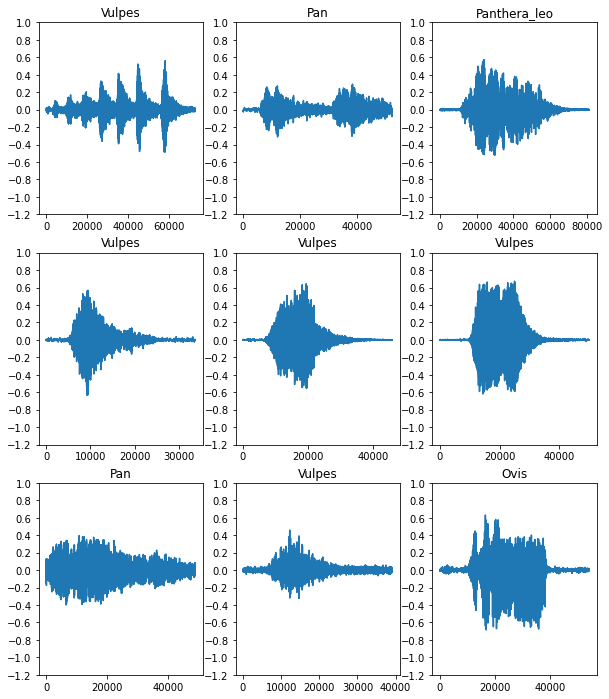

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spectrogram

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing. 

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.


In [18]:
frame_length = 255
frame_step = 255
num_mel_bins = 75
num_spectrogram_bins = (frame_length // 2) + 1
fmin = 0.0
sample_rate = 44100
fmax = sample_rate / 2

In [38]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([133300] - tf.shape(waveform), dtype=tf.float32)
    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    magnitude_spectrograms  = tf.signal.stft(
      equal_length, frame_length, frame_step)
    magnitude_spectrograms  = tf.abs(magnitude_spectrograms)
    
    # Step: magnitude_spectrograms->mel_spectrograms
    # Warp the linear-scale, magnitude spectrograms into the mel-scale.
    num_spectrogram_bins = magnitude_spectrograms.shape[-1]


    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, fmin,
        fmax)

    mel_spectrograms = tf.tensordot(
        magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

    mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(
  linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    #mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
    #  log_mel_spectrograms)[..., :75]
  
    return log_mel_spectrograms

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [39]:
for waveform, label in waveform_ds.take(147):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))

Label: Ovis
Waveform shape: (52426,)
Spectrogram shape: (522, 75)
Audio playback


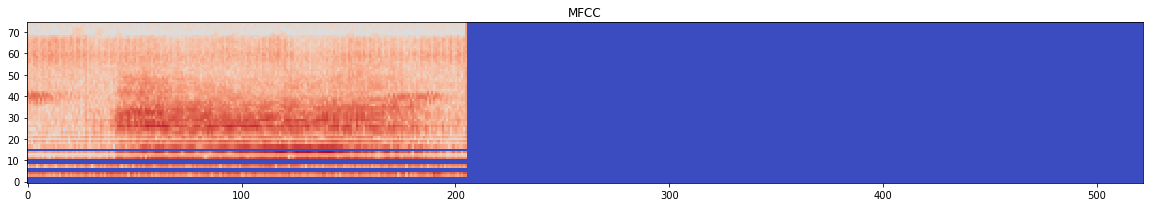

In [40]:
def plot_spectrogram(spectrogram):
  fig, ax = plt.subplots(figsize=(20,10))
  mfcc_data= np.swapaxes(spectrogram, 0 ,1)
  cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
  ax.set_title('MFCC')

plot_spectrogram(spectrogram)
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [41]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [42]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

## Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [43]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id)
  return output_ds

In [44]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [45]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [46]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [47]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (522, 75, 1)


In [48]:
#base_net = inception_v3.InceptionV3(weights="imagenet", include_top=False,
#	input_shape=input_shape, pooling="avg")

In [49]:
#for layer in base_net.layers:
 #   layer.trainable = False

In [50]:
# Output of the base_net model
#x = base_net.output
# intermediate fully-connected layer + ReLU
#x = tf.keras.layers.Dense(1024, activation='relu')(x)
# final fully-connected layer + SoftMax 
#pred = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

In [51]:
#model = tf.keras.Model(inputs=base_net.input, outputs=pred)

In [52]:
model = models.Sequential(
    [
        layers.Input(shape = input_shape),
        preprocessing.Resizing(32, 32), 
        layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'),
        layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
        layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(len(commands), activation='softmax')
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)         

In [53]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [54]:
EPOCHS = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,  
    epochs=EPOCHS,
)

Epoch 1/50
2/2 [==============================] - 1s 523ms/step - loss: 1.6288 - accuracy: 0.2051 - val_loss: 1.6798 - val_accuracy: 0.1333
Epoch 2/50
2/2 [==============================] - 0s 44ms/step - loss: 1.5855 - accuracy: 0.2393 - val_loss: 1.6661 - val_accuracy: 0.1333
Epoch 3/50
2/2 [==============================] - 0s 41ms/step - loss: 1.5786 - accuracy: 0.2393 - val_loss: 1.6527 - val_accuracy: 0.1333
Epoch 4/50
2/2 [==============================] - 0s 39ms/step - loss: 1.5495 - accuracy: 0.2991 - val_loss: 1.6902 - val_accuracy: 0.1333
Epoch 5/50
2/2 [==============================] - 0s 42ms/step - loss: 1.5090 - accuracy: 0.3846 - val_loss: 1.7059 - val_accuracy: 0.1333
Epoch 6/50
2/2 [==============================] - 0s 41ms/step - loss: 1.5223 - accuracy: 0.3504 - val_loss: 1.7052 - val_accuracy: 0.1333
Epoch 7/50
2/2 [==============================] - 0s 45ms/step - loss: 1.4847 - accuracy: 0.4188 - val_loss: 1.7112 - val_accuracy: 0.1333
Epoch 8/50
2/2 [==========

Let's check the training and validation loss curves to see how your model has improved during training.

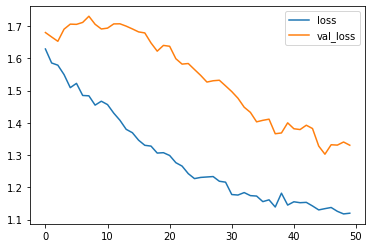

In [55]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [56]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [57]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 79%


### Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

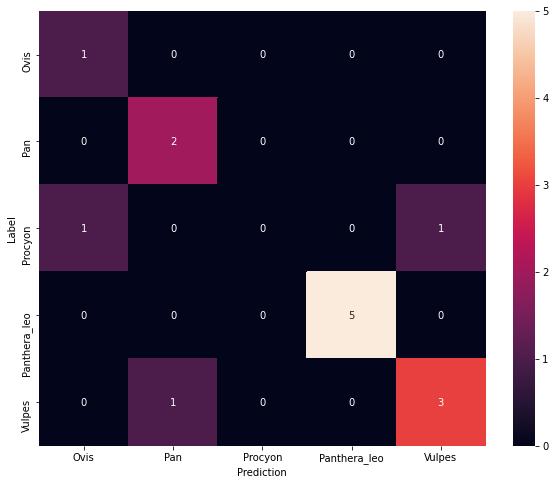

In [58]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file


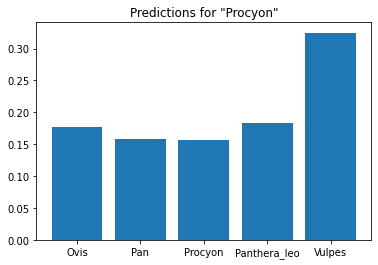

In [64]:
sample_file = test_files[2].numpy().decode("UTF-8")

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()